In [36]:
import pandas as pd
import numpy as np
# Adding necessary module:
import matplotlib.pyplot as plt
import seaborn as sns

def ReadData( fileName ):
    """This function takes a filename as input, and returns a dataframe with
    raw data read from that file in a Pandas DataFrame.  The DataFrame index
    should be the year, month and day of the observation.  DataFrame headers
    should be "Date", "Precip", "Max Temp", "Min Temp", "Wind Speed". Function
    returns the completed DataFrame, and a dictionary designed to contain all 
    missing value counts."""
    
    # define column names
    colNames = ['Date','Precip','Max Temp', 'Min Temp','Wind Speed']

    # open and read the file
    DataDF = pd.read_csv("DataQualityChecking.txt",header=None, names=colNames,  
                         delimiter=r"\s+",parse_dates=[0])
    DataDF = DataDF.set_index('Date')
    
    # define and initialize the missing data dictionary
    ReplacedValuesDF = pd.DataFrame(0, index=["1. No Data"], columns=colNames[1:])
     
    return( DataDF, ReplacedValuesDF )

# Check 1:
def Check01_RemoveNoDataValues( DataDF, ReplacedValuesDF ):
    """This check replaces the defined No Data value with the NumPy NaN value
    so that further analysis does not use the No Data values.  Function returns
    the modified DataFrame and a count of No Data values replaced."""
    
    # Adding code here to remove No Data Value, replace it with np.nan
    DataDF.replace(-999,np.nan,inplace = True)
    
    # Record the number of NaN values after replacement
    ReplacedValuesDF.loc['1. No Data',:] = DataDF.isna().sum()
    
    return( DataDF, ReplacedValuesDF )

    return( DataDF, ReplacedValuesDF )

# Check 2:
def Check02_GrossErrors( DataDF, ReplacedValuesDF ):
    """This function checks for gross errors, values well outside the expected 
    range, and removes them from the dataset.  The function returns modified 
    DataFrames with data the has passed, and counts of data that have not 
    passed the check."""
 
    # Precipitation error thresholds: 0 ≤ P ≤ 25; 
    DataDF['Precip'] = DataDF['Precip'].mask(DataDF['Precip']>25, np.nan)
    DataDF['Precip'] = DataDF['Precip'].mask(DataDF['Precip']<0, np.nan)
    
    # Temperature Error Threshold: -25≤ T ≤ 35, 
    DataDF['Max Temp'] = DataDF['Max Temp'].mask(DataDF['Max Temp']<-25, np.nan)
    DataDF['Max Temp'] = DataDF['Max Temp'].mask(DataDF['Max Temp']>35, np.nan)
    DataDF['Min Temp'] = DataDF['Min Temp'].mask(DataDF['Min Temp']<-25, np.nan)
    DataDF['Min Temp'] = DataDF['Min Temp'].mask(DataDF['Min Temp']>35, np.nan)
    
    # Windspeed Error Threshold: 0 ≤ WS ≤ 10
    DataDF['Wind Speed'][(DataDF['Wind Speed'] < 0)|(DataDF['Wind Speed'] >10)]=np.nan #using pipe 
    
    # Count number of out of range values and have been replaced by np.nan
    ReplacedValuesDF.loc['2. Gross Error'] = DataDF.isnull().sum() - ReplacedValuesDF.loc['1. No Data'] 
    
    return( DataDF, ReplacedValuesDF )

# Check 3:    
def Check03_TmaxTminSwapped( DataDF, ReplacedValuesDF ):
    """This function checks for days when maximum air temperture is less than
    minimum air temperature, and swaps the values when found.  The function 
    returns modified DataFrames with data that has been fixed, and with counts 
    of how many times the fix has been applied."""
    
    # Swapping
    count = 0
    min_temp = 0
    for i in range(len(DataDF)):
        if DataDF['Max Temp'][i] < DataDF['Min Temp'][i]:
            min_temp = DataDF['Max Temp'][i]
            DataDF['Max Temp'][i] = DataDF['Min Temp'][i]
            DataDF['Min Temp'][i] = min_temp
            count += 1
    
    #count the swapped number
    ReplacedValuesDF.loc["3. Swapped", :] = [0,count,count,0]

    return( DataDF, ReplacedValuesDF )

# Check 4:
def Check04_TmaxTminRange( DataDF, ReplacedValuesDF ):
    """This function checks for days when maximum air temperture minus 
    minimum air temperature exceeds a maximum range, and replaces both values 
    with NaNs when found.  The function returns modified DataFrames with data 
    that has been checked, and with counts of how many days of data have been 
    removed through the process."""
    
    # Range Checking
    count = 0
    for i in range(len(DataDF)):
        if DataDF['Max Temp'][i] - DataDF['Min Temp'][i] > 25:
            DataDF['Max Temp'][i] = np.nan
            DataDF['Min Temp'][i] = np.nan
            count += 1
    # Counting the Range Failure
    ReplacedValuesDF.loc["4. Range Fail", :] = [0,count,count,0]

    return( DataDF, ReplacedValuesDF )
    

# the following condition checks whether we are running as a script, in which 
# case run the test code, otherwise functions are being imported so do not.
# put the main routines from your code after this conditional check.

if __name__ == '__main__':

    fileName = "DataQualityChecking.txt"
    DataDF, ReplacedValuesDF = ReadData(fileName)
    
    print("\nRaw data.....\n", DataDF.describe())
    
    DataDF, ReplacedValuesDF = Check01_RemoveNoDataValues( DataDF, ReplacedValuesDF )
    
    print("\nMissing values removed.....\n", DataDF.describe())
    
    DataDF, ReplacedValuesDF = Check02_GrossErrors( DataDF, ReplacedValuesDF )
    
    print("\nCheck for gross errors complete.....\n", DataDF.describe())
    
    DataDF, ReplacedValuesDF = Check03_TmaxTminSwapped( DataDF, ReplacedValuesDF )
    
    print("\nCheck for swapped temperatures complete.....\n", DataDF.describe())
    
    DataDF, ReplacedValuesDF = Check04_TmaxTminRange( DataDF, ReplacedValuesDF )
    
    print("\nAll processing finished.....\n", DataDF.describe())
    print("\nFinal changed values counts.....\n", ReplacedValuesDF)



Raw data.....
            Precip    Max Temp    Min Temp  Wind Speed
count  731.000000  731.000000  731.000000  731.000000
mean     0.288098   14.167227    0.548413    2.904172
std     53.773216   54.738379   53.477046    1.597814
min   -999.000000 -999.000000 -999.000000   -2.500000
25%      0.000000    6.735000   -4.080000    2.045000
50%      0.000000   18.560000    3.610000    2.910000
75%      2.237500   26.195000   11.875000    3.600000
max    279.000000  194.800000   26.100000   39.900000

Missing values removed.....
            Precip    Max Temp    Min Temp  Wind Speed
count  729.000000  729.000000  729.000000  731.000000
mean     3.029630   16.946835    3.290658    2.904172
std     12.191541   13.293172   10.740052    1.597814
min     -3.475000  -10.080000  -82.600000   -2.500000
25%      0.000000    6.850000   -4.030000    2.045000
50%      0.000000   18.580000    3.680000    2.910000
75%      2.275000   26.200000   11.900000    3.600000
max    279.000000  194.800000   26.1

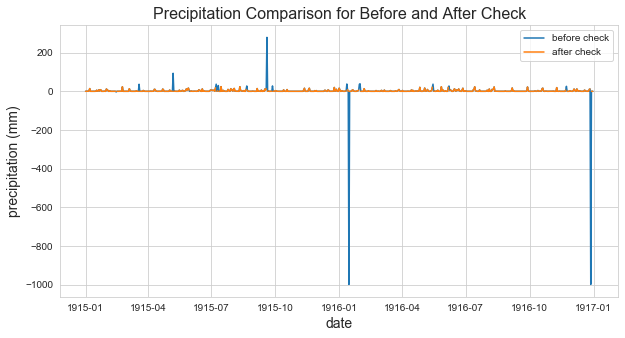

In [37]:
    # Calling Initial Data as the before comparison
    Data_in, ReplacedValues = ReadData(fileName)

    #Plot of precipitation
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 5))
    plt.plot(DataDF.index, Data_in['Precip'], label = "before check") 
    plt.plot(DataDF.index, DataDF['Precip'], label = "after check") 
    plt.xlabel('date', size=14)
    plt.ylabel('precipitation (mm)', size=14)
    plt.title('Precipitation Comparison for Before and After Check', size=16)
    plt.legend()
    plt.show()
    plt.savefig('precip_before_after_comparison.png')
    plt.close()


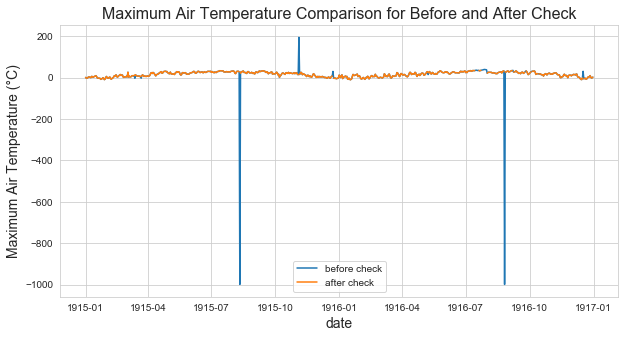

In [38]:
    #Plot of max temperature
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 5))
    plt.plot(DataDF.index, Data_in['Max Temp'], label = "before check") 
    plt.plot(DataDF.index, DataDF['Max Temp'], label = "after check") 
    plt.xlabel('date', size=14)
    plt.ylabel('Maximum Air Temperature (°C)', size=14)
    plt.title('Maximum Air Temperature Comparison for Before and After Check', size=16)
    plt.legend(loc='lower center')
    plt.show()
    plt.savefig('MaxTemp_before_after_comparison.png')
    plt.close()

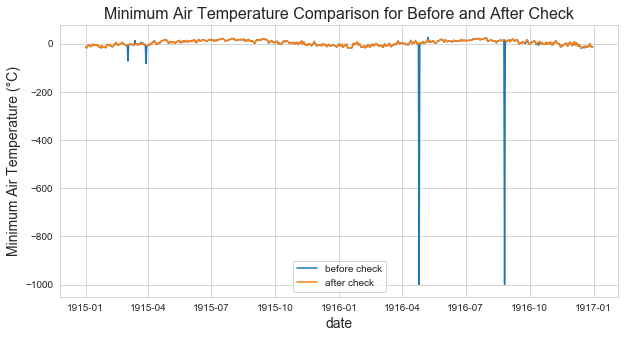

In [39]:
    # Minimum Air Temperature Comparison for Before and After Check
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 5))
    plt.plot(DataDF.index, Data_in['Min Temp'], label = "before check") 
    plt.plot(DataDF.index, DataDF['Min Temp'], label = "after check") 
    plt.xlabel('date', size=14)
    plt.ylabel('Minimum Air Temperature (°C)', size=14)
    plt.title('Minimum Air Temperature Comparison for Before and After Check', size=16)
    plt.legend(loc='lower center')
    plt.show()
    plt.savefig('MinTemp_before_after_comparison.png')
    plt.close()

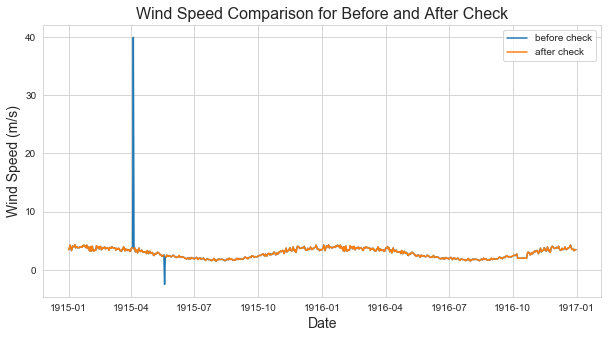

In [40]:
    # Wind Speed Comparison for Before and After Check
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 5))
    plt.plot(DataDF.index, Data_in['Wind Speed'], label = "before check") 
    plt.plot(DataDF.index, DataDF['Wind Speed'], label = "after check") 
    plt.xlabel('Date', size=14)
    plt.ylabel('Wind Speed (m/s)', size=14)
    plt.title('Wind Speed Comparison for Before and After Check', size=16)
    plt.legend(loc='best')
    plt.show()
    plt.savefig('Wind_before_after_comparison.png')
    plt.close()

In [41]:
    # Save modified data into another file
    DataDF.to_csv('Data_QC_Passed.txt', header = None, sep=' ') 
    ReplacedValuesDF.to_csv('Error_Checked.txt', sep='\t')

In [42]:
DataQC = pd.read_csv("Data_QC_Passed.txt",
                     header=None, 
                     #names=colNames,  
                     delimiter=" ",
                     #parse_dates=[0]
                    )

In [43]:
DataQC.head()

,0,1,2,3,4
0,1915-01-01,0.000,1.03,-15.84,3.48
1,1915-01-02,0.225,-1.73,-13.35,3.73
2,1915-01-03,0.000,-2.99,-17.00,4.25
3,1915-01-04,0.550,-1.19,-11.30,3.91
4,1915-01-05,0.000,2.95,-5.26,3.31


In [44]:
ErrorChecked = pd.read_csv("Error_Checked.txt",
                     header=None, 
                     #names=colNames,  
                     delimiter="\t",
                     #parse_dates=[0]
                    )

In [45]:
ErrorChecked

,0,1,2,3,4
0,NaN,Precip,Max Temp,Min Temp,Wind Speed
1,1. No Data,2.0,2.0,2.0,0.0
2,2. Gross Error,15.0,14.0,2.0,2.0
3,3. Swapped,0.0,4.0,4.0,0.0
4,4. Range Fail,0.0,5.0,5.0,0.0
